<a href="https://colab.research.google.com/github/AminPA/Heat-conduction/blob/master/LevelSet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
pip install lsml

In [ ]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from lsml.data.dim2 import hamburger
from lsml import LevelSetMachineLearning
from lsml.feature import get_basic_image_features, get_basic_shape_features
from lsml.initializer import RandomBallInitializer


random_state = np.random.RandomState(1234)


# Create a toy dataset ########################################################

n_samples = 200
imgs, segs = hamburger.make_dataset(
    N=n_samples, random_state=random_state)

# Set up the model and fit it #################################################

lsml = LevelSetMachineLearning(
    features=get_basic_image_features() + get_basic_shape_features(),
    initializer=RandomBallInitializer(random_state=random_state)
)

lsml.fit(
    'dataset.h5', imgs=imgs, segs=segs,
    max_iters=100, random_state=random_state,

    # We use a sklearn Pipeline as the regression model which is
    # simply a standard scaler followed by linear regression
    regression_model_class=Pipeline,
    regression_model_kwargs=dict(
        steps=[
            ('standardscaler', StandardScaler()),
            ('linearregressor', RandomForestRegressor()),
        ],
     )
)

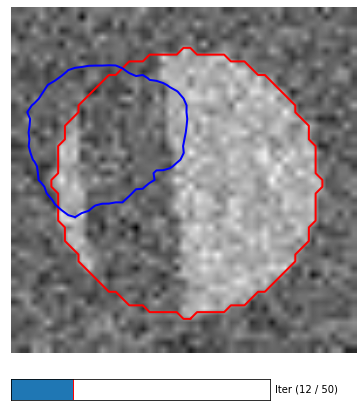

In [16]:
from lsml import LevelSetMachineLearning
from lsml.visualize import interactive2d


# Load the model and grab an example from the testing set
model = LevelSetMachineLearning.load('./LSML-model.pkl')
example = model.testing_data[0]

# Segment the example image
us = model.segment(img=example.img)

# View the example interactively
interactive2d(u=us, img=example.img, seg=example.seg)

ExecutableNotFoundError: ignored

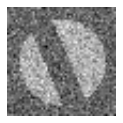

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import ImageMagickWriter

from lsml import LevelSetMachineLearning
from lsml.visualize import plot_iso_contours


# Load the model and an example
model = LevelSetMachineLearning.load('./LSML-model.pkl')
example = model.testing_data[13]


# Set up plotting for the movie frames
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.axis('off')
ax.imshow(example.img, cmap=plt.cm.gray, interpolation='bilinear')
lines = []


# Set up the movie writer and grab the frame at initialization
writer = ImageMagickWriter(fps=5)
writer.setup(fig, 'evolution.gif', 100)
writer.grab_frame()


# Define the callback function to be used during segmentation evolution
def update_movie(i, u):

    if i % 10 != 0:
        return

    for line in lines:
        line.remove()
    lines.clear()

    lines.extend(
        plot_iso_contours(ax, u, value=0, c='b')
    )
    ax.set_title("Iteration: {:d}".format(i))

    writer.grab_frame()


us = model.segment(img=example.img, on_iterate=[update_movie], verbose=True)

# Close out the movie writing
writer.finish()